In [2]:
import heapq
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Helper functions and classes
class Vertex:
    def __init__(self,x_coord,y_coord):
        self.x=x_coord
        self.y=y_coord
        self.d=float('inf') #distance from source
        self.parent_x=None
        self.parent_y=None
        self.processed=False
        self.index_in_queue=None

#Return neighbor directly above, below, right, and left
def get_neighbors(mat,r,c):
    shape=mat.shape
    neighbors=[]
    #ensure neighbors are within image boundaries
    if r > 0 and not mat[r-1][c].processed:
         neighbors.append(mat[r-1][c])
    if r < shape[0] - 1 and not mat[r+1][c].processed:
            neighbors.append(mat[r+1][c])
    if c > 0 and not mat[r][c-1].processed:
        neighbors.append(mat[r][c-1])
    if c < shape[1] - 1 and not mat[r][c+1].processed:
            neighbors.append(mat[r][c+1])
    return neighbors

def bubble_up(queue, index):
    if index <= 0:
        return queue
    p_index=(index-1)//2
    if queue[index].d < queue[p_index].d:
            queue[index], queue[p_index]=queue[p_index], queue[index]
            queue[index].index_in_queue=index
            queue[p_index].index_in_queue=p_index
            quque = bubble_up(queue, p_index)
    return queue
    
def bubble_down(queue, index):
    length=len(queue)
    lc_index=2*index+1
    rc_index=lc_index+1
    if lc_index >= length:
        return queue
    if lc_index < length and rc_index >= length: #just left child
        if queue[index].d > queue[lc_index].d:
            queue[index], queue[lc_index]=queue[lc_index], queue[index]
            queue[index].index_in_queue=index
            queue[lc_index].index_in_queue=lc_index
            queue = bubble_down(queue, lc_index)
    else:
        small = lc_index
        if queue[lc_index].d > queue[rc_index].d:
            small = rc_index
        if queue[small].d < queue[index].d:
            queue[index],queue[small]=queue[small],queue[index]
            queue[index].index_in_queue=index
            queue[small].index_in_queue=small
            queue = bubble_down(queue, small)
    return queue

def get_distance(img,u,v):
    return 0.1 + (float(img[v][0])-float(img[u][0]))**2+(float(img[v][1])-float(img[u][1]))**2+(float(img[v][2])-float(img[u][2]))**2

def drawPath(img,path, thickness=2):
    '''path is a list of (x,y) tuples'''
    x0,y0=path[0]
    for vertex in path[1:]:
        x1,y1=vertex
        cv2.line(img,(x0,y0),(x1,y1),(255,0,0),thickness)
        x0,y0=vertex

In [4]:
def find_shortest_path(img,src,dst):
    pq=[] #min-heap priority queue
    source_x=src[0]
    source_y=src[1]
    dest_x=dst[0]
    dest_y=dst[1]
    imagerows,imagecols=img.shape[0],img.shape[1]
    matrix = np.full((imagerows, imagecols), None) #access by matrix[row][col]
    for r in range(imagerows):
        for c in range(imagecols):
            matrix[r][c]=Vertex(c,r)
            matrix[r][c].index_in_queue=len(pq)
            pq.append(matrix[r][c])
    matrix[source_y][source_x].d=0
    pq=bubble_up(pq, matrix[source_y][source_x].index_in_queue)
    
    while len(pq) > 0:
        u=pq[0]
        u.processed=True
        pq[0]=pq[-1]
        pq[0].index_in_queue=0
        pq.pop()
        pq=bubble_down(pq,0)
        neighbors = get_neighbors(matrix,u.y,u.x)
        for v in neighbors:
            dist=get_distance(img,(u.y,u.x),(v.y,v.x))
            if u.d + dist < v.d:
                v.d = u.d+dist
                v.parent_x=u.x
                v.parent_y=u.y
                idx=v.index_in_queue
                pq=bubble_down(pq,idx)
                pq=bubble_up(pq,idx)
                          
    path=[]
    iter_v=matrix[dest_y][dest_x]
    path.append((dest_x,dest_y))
    while(iter_v.y!=source_y or iter_v.x!=source_x):
        path.append((iter_v.x,iter_v.y))
        iter_v=matrix[iter_v.parent_y][iter_v.parent_x]

        
    path.append((source_x,source_y))
    return path

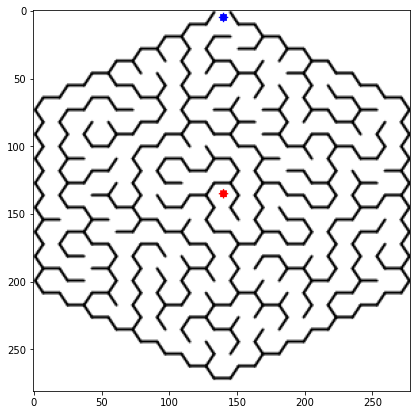

In [5]:
img = cv2.imread('drive/MyDrive/maze 19.png') # read the image 
cv2.circle(img,(140,135), 3, (255,0,0), -1) # add a circle at (5, 220)
cv2.circle(img, (140,5), 3, (0,0,255), -1) # add a circle at (5,5)
plt.figure(figsize=(7,7))
plt.imshow(img)  
plt.show()

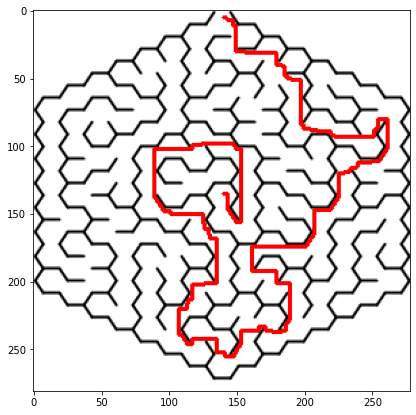

In [6]:
img = cv2.imread('drive/MyDrive/maze 19.png') # read the image 
cv2.imwrite('maze-initial.png', img)
p = find_shortest_path(img, (140,135), (140,5))
drawPath(img,p)
cv2.imwrite('maze-solution.png', img)
plt.figure(figsize=(7,7))
plt.imshow(img) # show the image on the screen 
plt.show()